In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from mlrose.algorithms import hill_climb

In [100]:
df = pd.read_csv('..\Data\worldcities.csv')
df=df[df.country=='Canada']
df = df.sort_values(by='lat')
lat = df.lat
lng = df.lng

In [192]:
coords_list = [(la, ln) for la, ln in zip(lat, lng)]
problem_no_fit = mlrose.TSPOpt(length = len(coords_list[0:50]), coords = coords_list[0:50], maximize=False)

In [206]:
best_state, best_fitness, curve = mlrose.simulated_annealing(problem_no_fit, random_state = 6, max_attempts=10000, curve=True)

C:\Users\lukep\anaconda3\lib\site-packages\mlrose\algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


In [207]:
lat_ordered = lat.values[best_state]
lng_ordered = lng.values[best_state]

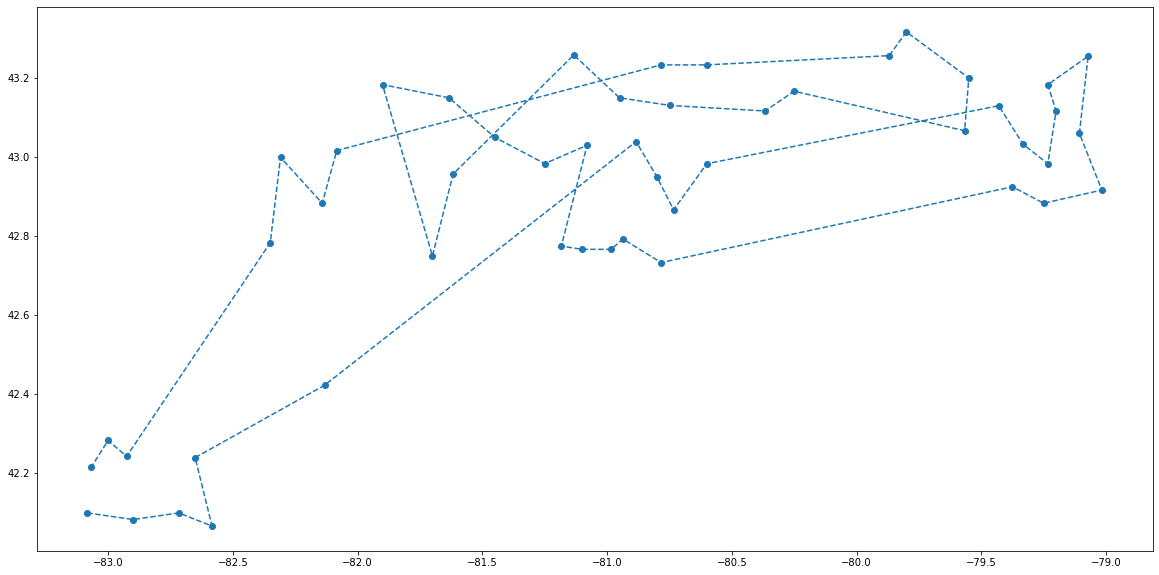

In [208]:
plt.figure(figsize=(20,10))
plt.plot(lng_ordered[0:100], lat_ordered[0:100], 'o--')

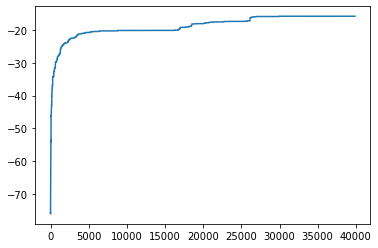

In [209]:
plt.plot(curve)